# Runtime

## Packages

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import gpboost as gpb
import requests
import pandas as pd
import time

/usr/sepp1.5.1/scratch/tmp/365/FP_data/FSAVecchia/FSVA_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Flag for toy example
toy = True

## Gaussian Data

In [3]:
# URL of the raw CSV file on GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/Data/simulated_data_Gaussian_5.txt'

# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
if toy:
    X = df.iloc[:10000, :5]
else:
    X = df.iloc[:, :5]  # First 5 columns

# Select the last column for y
if toy:
    y = df.iloc[:10000, -1]  # Last column
else:
    y = df.iloc[:, -1]  # Last column


In [4]:
# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

## Experiments

### Likelihood

In [11]:
# Different number of inducing points
vector_ind_points = [10, 20, 50, 100, 200, 500]
if toy:
    vector_ind_points = [10, 20, 50, 100, 150, 200]
# Different number of Vecchia neighbors
vector_vecchia = [5, 10, 15, 20, 30, 50]
# Different number of samples
vector_n = [10, 20, 30, 50, 80, 100]
if toy:
    vector_n = [1, 2, 3, 5, 8, 10]
# Zero matrices
matrix_t_vecchia = np.zeros((len(vector_vecchia), 1))
matrix_t_ip = np.zeros((len(vector_ind_points), 1))
matrix_t_n = np.zeros((len(vector_n), 1))
matrix_t_vecchia_v = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_v = np.zeros((len(vector_ind_points), 1))
matrix_t_n_v = np.zeros((len(vector_n), 1))
matrix_t_vecchia_f = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_f = np.zeros((len(vector_ind_points), 1))
matrix_t_n_f = np.zeros((len(vector_n), 1))
# number of repetitions
num_rep = 20
if toy:
    num_rep = 3
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_ind_points):
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)
        neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_ip[i, 0] = a/num_rep
    # Vecchia
    if i == 0:
        a = 0
        for j in range(0, num_rep):
            start_time = time.time()
            model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                     likelihood="gaussian",num_neighbors = 30,
                                     matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
            neg_v = model_v.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
            # End the timer
            end_time = time.time()
            a += end_time - start_time
        matrix_t_ip_v.fill(a/num_rep)
        

    # FITC
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_ind_points = val1,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_ip_f[i, 0] = a/num_rep
    
for i, val1 in enumerate(vector_vecchia):
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)
        neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_vecchia[i, 0] = a/num_rep

    # FITC
    if i == 0:
        a = 0
        for j in range(0, num_rep):
            start_time = time.time()
            model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                     likelihood="gaussian",num_ind_points = 200,ind_points_selection = "kmeans++",
                                     matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
            neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
            # End the timer
            end_time = time.time()
            a += end_time - start_time
        matrix_t_vecchia_f.fill(a/num_rep)

    # Vecchia
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                              likelihood="gaussian",num_neighbors = val1,
                              matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
        neg_v = model_v.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_vecchia_v[i, 0] = a/num_rep

for i, val1 in enumerate(vector_n):
    if val1 < 100:
        np.random.seed(1)
        indices = np.random.choice(X_np.shape[0], size=val1*1000, replace=False)
        # Select the downsampled data
        X_np_sampled = X_np[indices]
        y_np_sampled = y_np[indices]
    else:
        X_np_sampled = X_np
        y_np_sampled = y_np
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)
        neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_n[i, 0] = a/num_rep
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # Vecchia
        model_vecchia = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,
                                 matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
        neg_vecchia = model_vecchia.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_n_v[i, 0] = a/num_rep
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FITC
        model_fitc = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_n_f[i, 0] = a/num_rep

    

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

### Plots

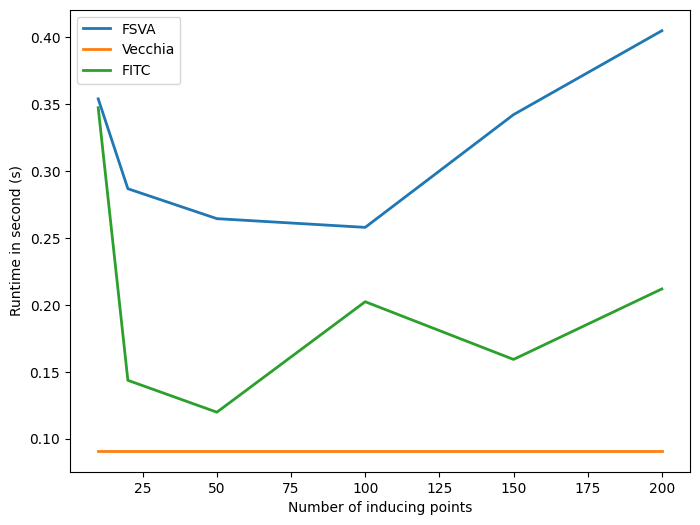

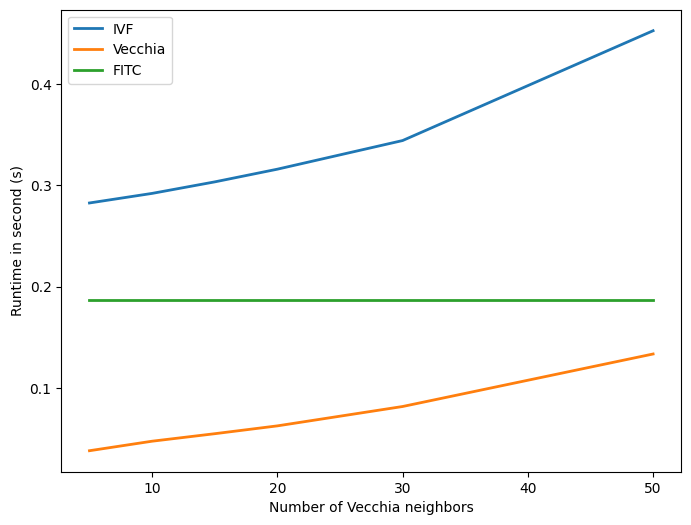

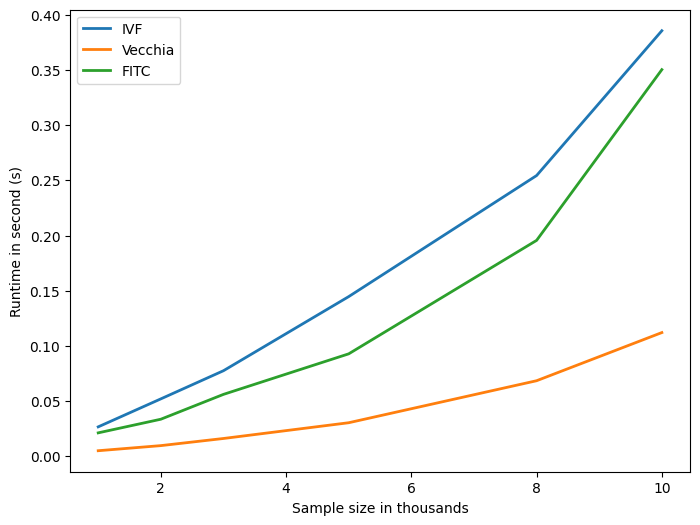

In [13]:
# Plot inducing points
plt.figure(figsize=(8, 6))
plt.plot(vector_ind_points, matrix_t_ip, label='FSVA', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_v, label='Vecchia', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of inducing points')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot Vecchia neighbors
plt.figure(figsize=(8, 6))
plt.plot(vector_vecchia, matrix_t_vecchia, label='IVF', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_v, label='Vecchia', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of Vecchia neighbors')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot sample size
plt.figure(figsize=(8, 6))
plt.plot(vector_n, matrix_t_n, label='IVF', linewidth=2)
plt.plot(vector_n, matrix_t_n_v, label='Vecchia', linewidth=2)
plt.plot(vector_n, matrix_t_n_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Sample size in thousands')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

### Prediction

In [11]:
# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
if toy:
    X = df.iloc[:10000, :5]
    X_p = df.iloc[10000:20000, :5]
else:
    X = df.iloc[:50000, :5]  # First 5 columns
    X_p = df.iloc[50000:100000, :5]

# Select the last column for y
if toy:
    y = df.iloc[:10000, -1]  # Last column
    y_p = df.iloc[10000:20000, -1]
else:
    y = df.iloc[:50000, -1]  # Last column
    y_p = df.iloc[50000:100000, -1]

# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

X_p = X_p.to_numpy()
y_p = y_p.to_numpy()

In [15]:
# Different number of inducing points
vector_ind_points = [10, 20, 50, 100, 200, 500]
if toy:
    vector_ind_points = [10, 20, 50, 100, 150, 200]
# Different number of Vecchia neighbors
vector_vecchia = [5, 10, 15, 20, 30, 50]
# Different number of samples
vector_n = [10, 20, 30, 50]
if toy:
    vector_n = [1, 2, 3, 5, 8, 10]
# Zero matrices
matrix_t_vecchia = np.zeros((len(vector_vecchia), 1))
matrix_t_ip = np.zeros((len(vector_ind_points), 1))
matrix_t_n = np.zeros((len(vector_n), 1))
matrix_t_vecchia_v = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_v = np.zeros((len(vector_ind_points), 1))
matrix_t_n_v = np.zeros((len(vector_n), 1))
matrix_t_vecchia_f = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_f = np.zeros((len(vector_ind_points), 1))
matrix_t_n_f = np.zeros((len(vector_n), 1))
# number of repetitions
num_rep = 20
if toy:
    num_rep = 3
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_ind_points):
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)
        neg_fsva = model_fsva.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_ip[i, 0] = a/num_rep
    # Vecchia
    if i == 0:
        a = 0
        for j in range(0, num_rep):
            start_time = time.time()
            model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                     likelihood="gaussian",num_neighbors = 30,
                                     matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
            neg_v = model_v.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
            # End the timer
            end_time = time.time()
            a += end_time - start_time
        matrix_t_ip_v.fill(a/num_rep)
        

    # FITC
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_ind_points = val1,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_ip_f[i, 0] = a/num_rep
    
for i, val1 in enumerate(vector_vecchia):
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)
        neg_fsva = model_fsva.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_vecchia[i, 0] = a/num_rep

    # FITC
    if i == 0:
        a = 0
        for j in range(0, num_rep):
            start_time = time.time()
            model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                     likelihood="gaussian",num_ind_points = 200,ind_points_selection = "kmeans++",
                                     matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
            neg_fitc = model_fitc.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
            # End the timer
            end_time = time.time()
            a += end_time - start_time
        matrix_t_vecchia_f.fill(a/num_rep)

    # Vecchia
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                              likelihood="gaussian",num_neighbors = val1,
                              matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
        neg_v = model_v.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_vecchia_v[i, 0] = a/num_rep

for i, val1 in enumerate(vector_n):
    if val1 < 100:
        np.random.seed(1)
        indices = np.random.choice(X_np.shape[0], size=val1*1000, replace=False)
        # Select the downsampled data
        X_np_sampled = X_np[indices]
        y_np_sampled = y_np[indices]
        X_p_sampled = X_p[indices]
        y_p_sampled = y_p[indices]
    else:
        X_np_sampled = X_np
        y_np_sampled = y_np
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)
        neg_fsva = model_fsva.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_n[i, 0] = a/num_rep
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # Vecchia
        model_vecchia = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_neighbors = 30,
                                 matrix_inversion_method = "cholesky", gp_approx="vecchia",seed = 10)
        neg_vecchia = model_vecchia.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_n_v[i, 0] = a/num_rep
    a = 0
    for j in range(0, num_rep):
        start_time = time.time()
        # FITC
        model_fitc = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                                 likelihood="gaussian",num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([0.3, 1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
        # End the timer
        end_time = time.time()
        a += end_time - start_time
    matrix_t_n_f[i, 0] = a/num_rep

    

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

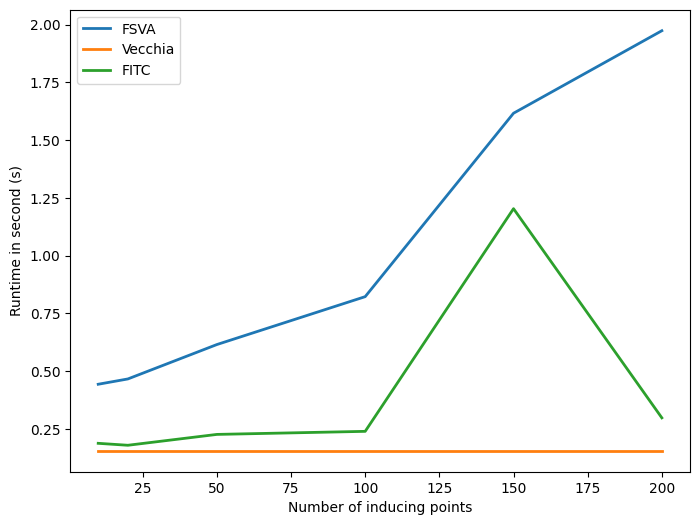

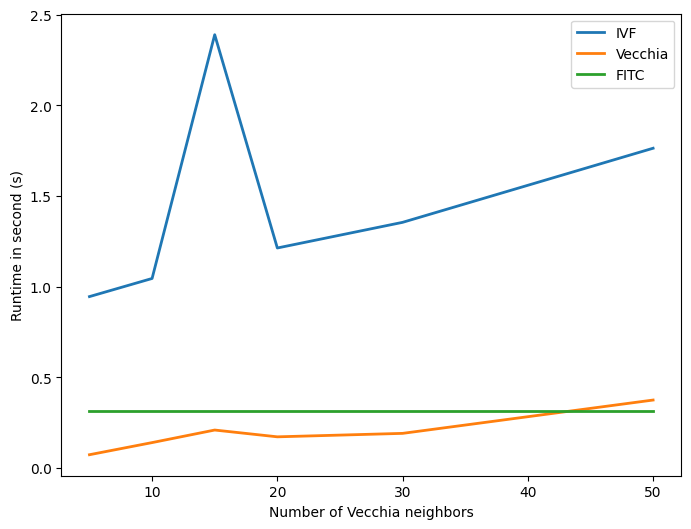

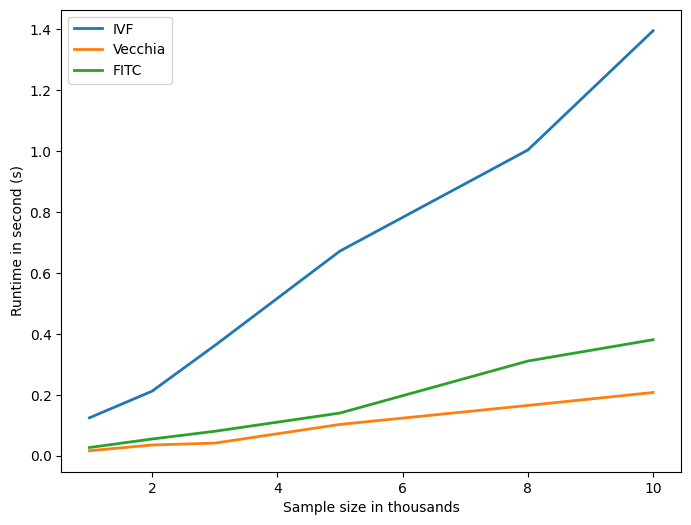

In [16]:
# Plot inducing points
plt.figure(figsize=(8, 6))
plt.plot(vector_ind_points, matrix_t_ip, label='FSVA', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_v, label='Vecchia', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of inducing points')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot Vecchia neighbors
plt.figure(figsize=(8, 6))
plt.plot(vector_vecchia, matrix_t_vecchia, label='IVF', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_v, label='Vecchia', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of Vecchia neighbors')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot sample size
plt.figure(figsize=(8, 6))
plt.plot(vector_n, matrix_t_n, label='IVF', linewidth=2)
plt.plot(vector_n, matrix_t_n_v, label='Vecchia', linewidth=2)
plt.plot(vector_n, matrix_t_n_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Sample size in thousands')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

## Non-Gaussian Data

In [3]:
# URL of the raw CSV file on GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/Data/simulated_data_non_Gaussian_5.txt'

# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
if toy:
    X = df.iloc[:10000, :5]
else:
    X = df.iloc[:, :5]  # First 5 columns

# Select the last column for y
if toy:
    y = df.iloc[:10000, 5]  # Last column
else:
    y = df.iloc[:, 5]  # Last column

In [4]:
# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

## Experiments

### Likelihood

In [5]:
# Different number of inducing points
vector_ind_points = [10, 20, 50, 100, 200, 500]
if toy:
    vector_ind_points = [10, 20, 50, 100, 150, 200]
# Different number of Vecchia neighbors
vector_vecchia = [5, 10, 15, 20, 30, 50]
# Different number of samples
vector_n = [10, 20, 30, 50, 80, 100]
if toy:
    vector_n = [1, 2, 3, 5, 8, 10]
# Zero matrices
matrix_t_vecchia_p1 = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_p1 = np.zeros((len(vector_ind_points), 1))
matrix_t_n_p1 = np.zeros((len(vector_n), 1))
matrix_t_vecchia_p2 = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_p2 = np.zeros((len(vector_ind_points), 1))
matrix_t_n_p2 = np.zeros((len(vector_n), 1))

matrix_t_vecchia_v = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_v = np.zeros((len(vector_ind_points), 1))
matrix_t_n_v = np.zeros((len(vector_n), 1))
matrix_t_vecchia_f = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_f = np.zeros((len(vector_ind_points), 1))
matrix_t_n_f = np.zeros((len(vector_n), 1))
# number of repetitions
num_rep = 20
if toy:
    num_rep = 3
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_ind_points):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_p2[i, 0] = end_time - start_time

    # Vecchia
    if i == 0:
        start_time = time.time()
        model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,
                                 matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
        neg_v = model_v.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
        # End the timer
        end_time = time.time()
        matrix_t_ip_v.fill(end_time - start_time)

    # FITC
    start_time = time.time()
    model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_ind_points = 100,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_ip_f[i, 0] = end_time - start_time
    
for i, val1 in enumerate(vector_vecchia):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_p2[i, 0] = end_time - start_time

    # FITC
    if i == 0:
        start_time = time.time()
        model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
        # End the timer
        end_time = time.time()
        matrix_t_vecchia_f.fill(end_time - start_time)

    # Vecchia
    start_time = time.time()
    model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                          likelihood="bernoulli_logit",num_neighbors = val1,
                          matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
    neg_v = model_v.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_v[i, 0] = end_time - start_time

for i, val1 in enumerate(vector_n):
    if val1 < 100:
        np.random.seed(1)
        indices = np.random.choice(X_np.shape[0], size=val1*1000, replace=False)
        # Select the downsampled data
        X_np_sampled = X_np[indices]
        y_np_sampled = y_np[indices]
    else:
        X_np_sampled = X_np
        y_np_sampled = y_np
    
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    neg_fsva = model_fsva.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_p2[i, 0] = end_time - start_time

    # Vecchia
    start_time = time.time()
    model_vecchia = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
    neg_vecchia = model_vecchia.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_v[i, 0] = end_time - start_time

    # FITC
    start_time = time.time()
    model_fitc = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.neg_log_likelihood(cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), y = y_np_sampled)
    # End the timer
    end_time = time.time()
    matrix_t_n_f[i, 0] = end_time - start_time

    

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

### Plots

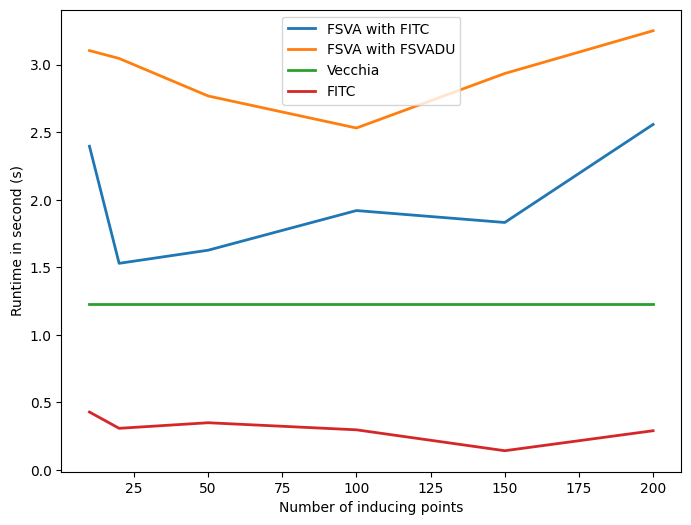

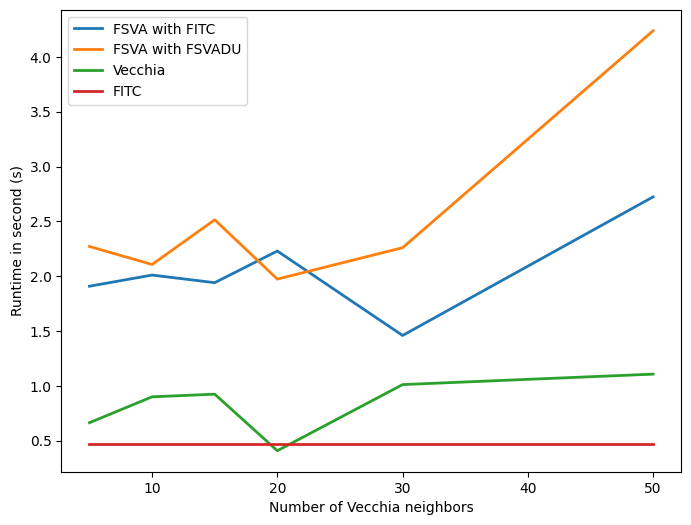

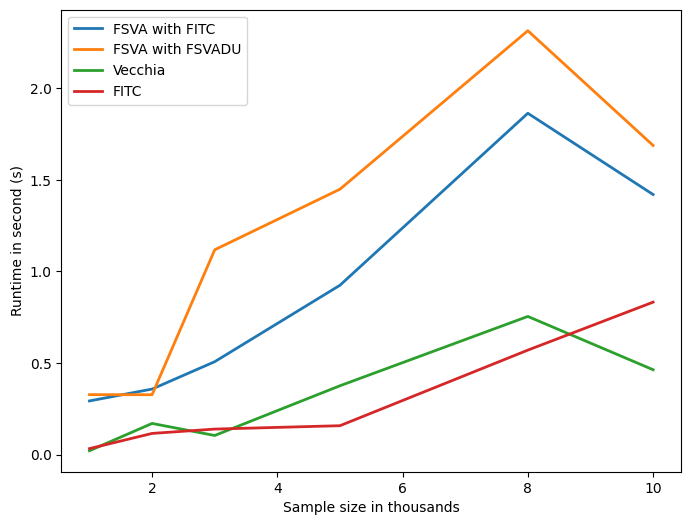

In [6]:
# Plot inducing points
plt.figure(figsize=(8, 6))
plt.plot(vector_ind_points, matrix_t_ip_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_p2, label='FSVA with VIFDU', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_v, label='Vecchia', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of inducing points')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot Vecchia neighbors
plt.figure(figsize=(8, 6))
plt.plot(vector_vecchia, matrix_t_vecchia_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_p2, label='FSVA with VIFDU', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_v, label='Vecchia', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of Vecchia neighbors')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot sample size
plt.figure(figsize=(8, 6))
plt.plot(vector_n, matrix_t_n_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_n, matrix_t_n_p2, label='FSVA with VIFDU', linewidth=2)
plt.plot(vector_n, matrix_t_n_v, label='Vecchia', linewidth=2)
plt.plot(vector_n, matrix_t_n_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Sample size in thousands')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

### Prediction

In [5]:
# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
if toy:
    X = df.iloc[:10000, :5]
    X_p = df.iloc[10000:20000, :5]
else:
    X = df.iloc[:50000, :5]  # First 5 columns
    X_p = df.iloc[50000:100000, :5]

# Select the last column for y
if toy:
    y = df.iloc[:10000, 5]  # Last column
    y_p = df.iloc[10000:20000, 5]
else:
    y = df.iloc[:50000, 5]  # Last column
    y_p = df.iloc[50000:100000, 5]

    
# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

X_p = X_p.to_numpy()
y_p = y_p.to_numpy()

In [6]:
# Different number of inducing points
vector_ind_points = [10, 20, 50, 100, 200, 500]
if toy:
    vector_ind_points = [50, 100, 150, 200]
# Different number of Vecchia neighbors
vector_vecchia = [5, 10, 15, 20, 30, 50]
# Different number of samples
vector_n = [10, 20, 30, 50, 80, 100]
if toy:
    vector_n = [1, 2, 3, 5, 8, 10]
# Zero matrices
matrix_t_vecchia_p1 = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_p1 = np.zeros((len(vector_ind_points), 1))
matrix_t_n_p1 = np.zeros((len(vector_n), 1))
matrix_t_vecchia_p2 = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_p2 = np.zeros((len(vector_ind_points), 1))
matrix_t_n_p2 = np.zeros((len(vector_n), 1))

matrix_t_vecchia_v = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_v = np.zeros((len(vector_ind_points), 1))
matrix_t_n_v = np.zeros((len(vector_n), 1))
matrix_t_vecchia_f = np.zeros((len(vector_vecchia), 1))
matrix_t_ip_f = np.zeros((len(vector_ind_points), 1))
matrix_t_n_f = np.zeros((len(vector_n), 1))

# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_ind_points):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                        "piv_chol_rank": 200})
    model_fsva.set_prediction_data(nsim_var_pred = 100)
    neg_fsva = model_fsva.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_ip_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = val1,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    model_fsva.set_prediction_data(nsim_var_pred = 100)
    neg_fsva = model_fsva.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_ip_p2[i, 0] = end_time - start_time
    
    # Vecchia
    if i == 0:
        start_time = time.time()
        model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,
                                 matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
        neg_v = model_v.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
        # End the timer
        end_time = time.time()
        matrix_t_ip_v.fill(end_time - start_time)
        
    # FITC
    start_time = time.time()
    model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_ind_points = 100,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_ip_f[i, 0] = end_time - start_time
    
for i, val1 in enumerate(vector_vecchia):
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    model_fsva.set_prediction_data(nsim_var_pred = 100)
    neg_fsva = model_fsva.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = val1,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    model_fsva.set_prediction_data(nsim_var_pred = 100)
    neg_fsva = model_fsva.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_p2[i, 0] = end_time - start_time

    # FITC
    if i == 0:
        start_time = time.time()
        model_fitc = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
        neg_fitc = model_fitc.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
        # End the timer
        end_time = time.time()
        matrix_t_vecchia_f.fill(end_time - start_time)

    # Vecchia
    start_time = time.time()
    model_v = gpb.GPModel(gp_coords=X_np, cov_function="gaussian_ard", 
                          likelihood="bernoulli_logit",num_neighbors = val1,
                          matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
    neg_v = model_v.predict(gp_coords_pred = X_p, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_vecchia_v[i, 0] = end_time - start_time

for i, val1 in enumerate(vector_n):
    if val1 < 100:
        np.random.seed(1)
        indices = np.random.choice(X_np.shape[0], size=val1*1000, replace=False)
        # Select the downsampled data
        X_np_sampled = X_np[indices]
        y_np_sampled = y_np[indices]
        X_p_sampled = X_p[indices]
        y_p_sampled = y_p[indices]
    else:
        X_np_sampled = X_np
        y_np_sampled = y_np
    
    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200})
    model_fsva.set_prediction_data(nsim_var_pred = 100)
    neg_fsva = model_fsva.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_n_p1[i, 0] = end_time - start_time

    start_time = time.time()
    # FSVecchia with euclidean-based neighbor search
    model_fsva = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
    model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B"})
    model_fsva.set_prediction_data(nsim_var_pred = 500)
    neg_fsva = model_fsva.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_n_p2[i, 0] = end_time - start_time

    # Vecchia
    start_time = time.time()
    model_vecchia = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_neighbors = 30,
                             matrix_inversion_method = "iterative", gp_approx="vecchia",seed = 10)
    neg_vecchia = model_vecchia.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_n_v[i, 0] = end_time - start_time

    # FITC
    start_time = time.time()
    model_fitc = gpb.GPModel(gp_coords=X_np_sampled, cov_function="gaussian_ard", 
                             likelihood="bernoulli_logit",num_ind_points = 200,ind_points_selection = "kmeans++",
                             matrix_inversion_method = "cholesky", gp_approx="fitc",seed = 10)
    neg_fitc = model_fitc.predict(gp_coords_pred = X_p_sampled, 
                                      cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]), 
                                      y = y_np_sampled, predict_var = True)
    # End the timer
    end_time = time.time()
    matrix_t_n_f[i, 0] = end_time - start_time

    

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing

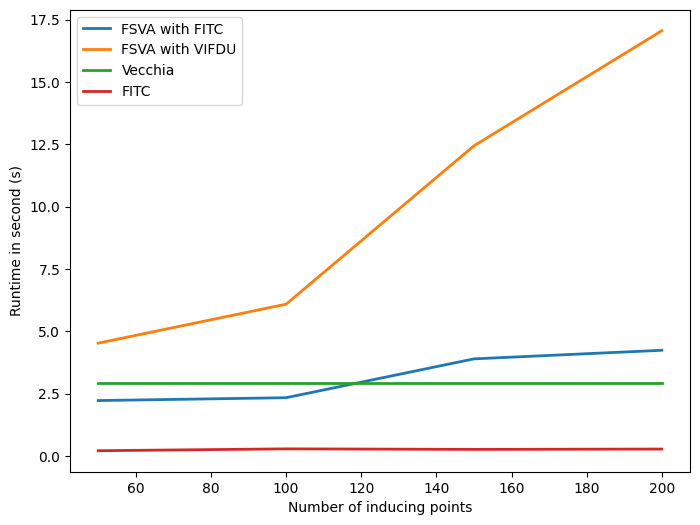

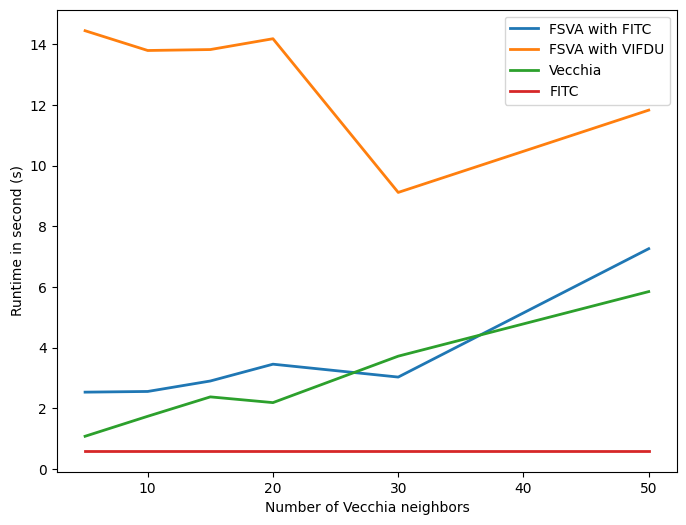

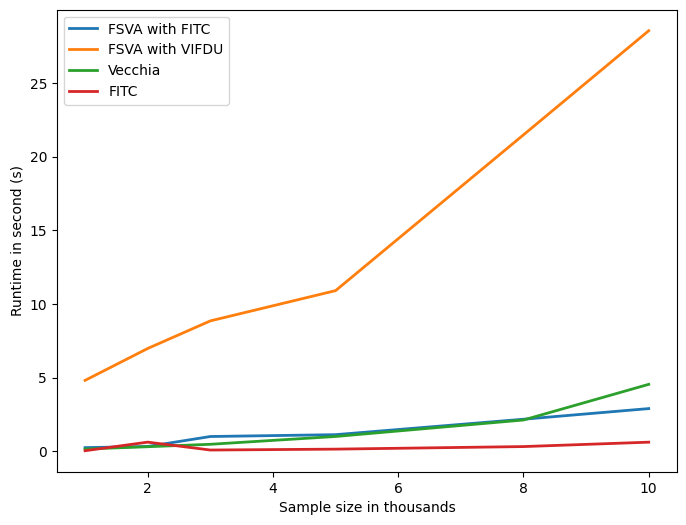

In [7]:
# Plot inducing points
plt.figure(figsize=(8, 6))
plt.plot(vector_ind_points, matrix_t_ip_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_p2, label='FSVA with VIFDU', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_v, label='Vecchia', linewidth=2)
plt.plot(vector_ind_points, matrix_t_ip_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of inducing points')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot Vecchia neighbors
plt.figure(figsize=(8, 6))
plt.plot(vector_vecchia, matrix_t_vecchia_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_p2, label='FSVA with VIFDU', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_v, label='Vecchia', linewidth=2)
plt.plot(vector_vecchia, matrix_t_vecchia_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Number of Vecchia neighbors')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Plot sample size
plt.figure(figsize=(8, 6))
plt.plot(vector_n, matrix_t_n_p1, label='FSVA with FITC', linewidth=2)
plt.plot(vector_n, matrix_t_n_p2, label='FSVA with VIFDU', linewidth=2)
plt.plot(vector_n, matrix_t_n_v, label='Vecchia', linewidth=2)
plt.plot(vector_n, matrix_t_n_f, label='FITC', linewidth=2)

# Add labels and title
plt.xlabel('Sample size in thousands')
plt.ylabel('Runtime in second (s)')

# Display the legend
plt.legend()

# Show the plot
plt.show()